In [16]:
from datetime import datetime
from meteostat import Daily
import ssl

# Set SSL context.
ssl._create_default_https_context = ssl._create_unverified_context

# Set time period.
start = datetime(2019, 1, 1)
end = datetime(2023, 12, 30)

# Get daily data.
weather_data = Daily('10381', start, end)
weather_data = weather_data.fetch()

# Drop unnecessary columns, reset index and rename.
weather_data = weather_data.reset_index()
weather_data = weather_data.drop(columns=['tmin', 'tmax', 'wdir', 'wspd', 'pres', 'wpgt', 'tsun'])
weather_data = weather_data.rename(columns={'time': 'date', 'tavg': 'avg_temperature', 'prcp': 'precipitation', 'snow': 'snow(mm)'})

# Convert the date from "YYYY-MM-DD" to "DD.MM.YYYY" in the data frame.
weather_data['date'] = weather_data['date'].dt.strftime('%d.%m.%Y')

# Set the date as the index.
weather_data = weather_data.set_index('date')

# Export to csv.
weather_data.to_csv('../data/weather.csv')

weather_data.head()

,avg_temperature,precipitation,snow(mm)
date,,,
01.01.2019,6.4,2.2,0.0
02.01.2019,1.8,0.1,0.0
03.01.2019,-0.4,0.0,0.0
04.01.2019,1.8,1.9,0.0
05.01.2019,6.0,0.0,0.0


In [17]:
import pandas as pd

# Read trash data and separate by semicolon.
trash_data = pd.read_csv('../data/trash-amounts.csv', sep=';')

# Rename Datum header to date and set it as the index.
trash_data = trash_data.rename(columns={'Datum': 'date'})
trash_data = trash_data.set_index('date')

# Convert date from "DD.MM.YY" to "DD.MM.YYYY".
trash_data.index = pd.to_datetime(trash_data.index, format='%d.%m.%y')
trash_data.index = trash_data.index.strftime('%d.%m.%Y')

# Add weather data columns to trash data.
weather_trash_data = trash_data.join(weather_data)

# Export the frame to a csv file for later processing.
weather_trash_data.to_csv('../data/weather-trash.csv')

# Remove completely empty rows.
weather_trash_data = weather_trash_data.dropna(how='all')

# Convert Tonnage to numeric and replace commas with dots.
weather_trash_data['Tonnage'] = pd.to_numeric(weather_trash_data['Tonnage'].str.replace(',', '.'))

# Export the frame to a csv file for later processing.
weather_trash_data.to_csv('../data/weather-trash.csv')

weather_trash_data.head()


,Monat,KW,Jahr,Hof,Schicht,Tour,Tonnage,Abfallart,avg_temperature,precipitation,snow(mm)
date,,,,,,,,,,,
02.01.2019,1.0,1.0,2019.0,VMF,1.0,1.0,5.59,BIO,1.8,0.1,0.0
02.01.2019,1.0,1.0,2019.0,VMF,1.0,4.0,3.23,BIO,1.8,0.1,0.0
02.01.2019,1.0,1.0,2019.0,VMF,1.0,5.0,5.68,BIO,1.8,0.1,0.0
02.01.2019,1.0,1.0,2019.0,VMF,1.0,6.0,5.48,BIO,1.8,0.1,0.0
02.01.2019,1.0,1.0,2019.0,VMF,1.0,7.0,7.84,BIO,1.8,0.1,0.0


In [18]:
# Make a correlation matrix between temperature, precipitation and tonnage.
correlation_matrix = weather_trash_data[['avg_temperature', 'precipitation', 'Tonnage']].corr()

# Print the correlation matrix.
print(correlation_matrix)

                 avg_temperature  precipitation  Tonnage
avg_temperature         1.000000       0.057945 -0.02263
precipitation           0.057945       1.000000 -0.00792
Tonnage                -0.022630      -0.007920  1.00000


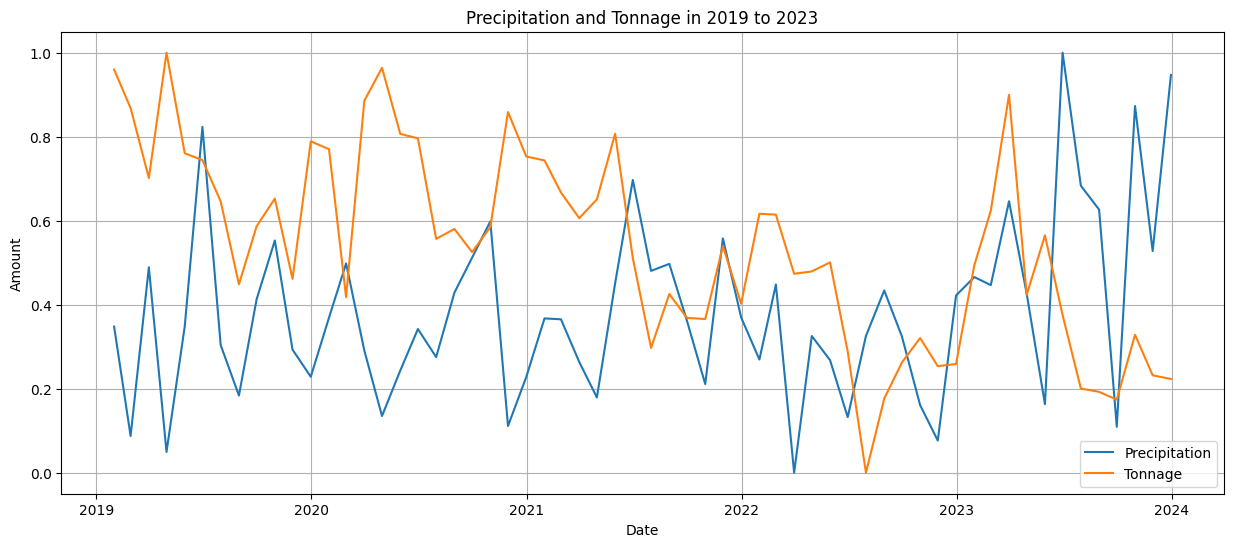

In [19]:
import matplotlib.pyplot as plt

# Create new df with only precipitation and tonnage.
precipitation_tonnage = weather_trash_data[['precipitation', 'Tonnage']]

# Convert dates to datetime objects.
precipitation_tonnage.index = pd.to_datetime(precipitation_tonnage.index, format='%d.%m.%Y')

# Group by date and calculate the mean for tonnage.
precipitation_tonnage = precipitation_tonnage.groupby('date').mean()

# Resample the data to weekly.
precipitation_tonnage = precipitation_tonnage.resample('ME').mean()

# Remove where precipitation or tonnage is not available.
precipitation_tonnage = precipitation_tonnage.dropna()

# Normalize the data to be between 0 and 1.
precipitation_tonnage = (precipitation_tonnage - precipitation_tonnage.min()) / (precipitation_tonnage.max() - precipitation_tonnage.min())

# Plot the data.
plt.figure(figsize=(15, 6))
plt.plot(precipitation_tonnage['precipitation'], label='Precipitation')
plt.plot(precipitation_tonnage['Tonnage'], label='Tonnage')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Precipitation and Tonnage in 2019 to 2023')
plt.grid(True)
plt.legend()
plt.show()

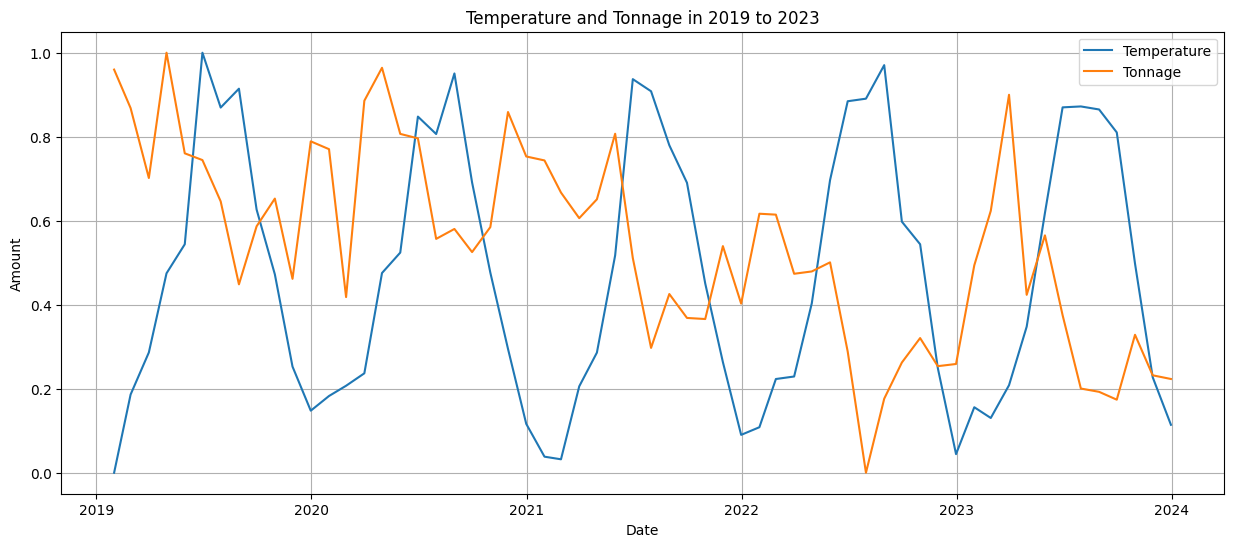

In [20]:
# Do the same as above for temperature.
temperature_tonnage = weather_trash_data[['avg_temperature', 'Tonnage']]
temperature_tonnage.index = pd.to_datetime(temperature_tonnage.index, format='%d.%m.%Y')
temperature_tonnage = temperature_tonnage.groupby('date').mean()
temperature_tonnage = temperature_tonnage.resample('ME').mean()

temperature_tonnage = temperature_tonnage.dropna()

# Normalize the data to be between 0 and 1.
temperature_tonnage = (temperature_tonnage - temperature_tonnage.min()) / (temperature_tonnage.max() - temperature_tonnage.min())

plt.figure(figsize=(15, 6))
plt.plot(temperature_tonnage['avg_temperature'], label='Temperature')
plt.plot(temperature_tonnage['Tonnage'], label='Tonnage')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Temperature and Tonnage in 2019 to 2023')
plt.legend()
plt.grid(True)
plt.show()